In [1]:
# 0. 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수 
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)


# 1. 데이터 준비하기

# 코드 사전 정의
code2idx = {'c_oct1_1':0, 'd_oct1_1':1, 'e_oct1_1':2, 'f_oct1_1':3, 'g_oct1_1':4, 'a_oct1_1':5, 'b_oct1_1':6, \
            'c_oct1_2':7, 'd_oct1_2':8, 'e_oct1_2':9, 'f_oct1_2':10, 'g_oct1_2':11, 'a_oct1_2':12, 'b_oct1_2':13, \
            'c_oct1_3':14, 'd_oct1_3':15, 'e_oct1_3':16, 'f_oct1_3':17, 'g_oct1_3':18, 'a_oct1_3':19, 'b_oct1_3':20, \
            'c_oct2_1':21, 'd_oct2_1':22, 'e_oct2_1':23, 'f_oct2_1':24, 'g_oct2_1':25, 'a_oct2_1':26, 'b_oct2_1':27, \
            'c_oct2_2':28, 'd_oct2_2':29, 'e_oct2_2':30, 'f_oct2_2':31, 'g_oct2_2':32, 'a_oct2_2':33, 'b_oct2_2':34, \
            'c_oct2_3':35, 'd_oct2_3':36, 'e_oct2_3':37, 'f_oct2_3':38, 'g_oct2_3':39, 'a_oct2_3':40, 'b_oct2_3':41, \
            'c_oct0_1':42, 'd_oct0_1':43, 'e_oct0_1':44, 'f_oct0_1':45, 'g_oct0_1':46, 'a_oct0_1':47, 'b_oct0_1':48, \
            'c_oct0_2':49, 'd_oct0_2':50, 'e_oct0_2':51, 'f_oct0_2':52, 'g_oct0_2':53, 'a_oct0_2':54, 'b_oct0_2':55, \
            'c_oct0_3':56, 'd_oct0_3':57, 'e_oct0_3':58, 'f_oct0_3':59, 'g_oct0_3':60, 'a_oct0_3':61, 'b_oct0_3':62, \
            'c_oct1_1_legSt':63, 'd_oct1_1_legSt':64, 'e_oct1_1_legSt':65, 'f_oct1_1_legSt':66, 'g_oct1_1_legSt':67, 'a_oct1_1_legSt':68, 'b_oct1_1_legSt':69, \
            'c_oct1_2_legSt':70, 'd_oct1_2_legSt':71, 'e_oct1_2_legSt':72, 'f_oct1_2_legSt':73, 'g_oct1_2_legSt':74, 'a_oct1_2_legSt':75, 'b_oct1_2_legSt':76, \
            'c_oct1_3_legSt':77, 'd_oct1_3_legSt':78, 'e_oct1_3_legSt':79, 'f_oct1_3_legSt':80, 'g_oct1_3_legSt':81, 'a_oct1_3_legSt':82, 'b_oct1_3_legSt':83, \
            'c_oct1_1_legEnd':84, 'd_oct1_1_legEnd':85, 'e_oct1_1_legEnd':86, 'f_oct1_1_legEnd':87, 'g_oct1_1_legEnd':88, 'a_oct1_1_legEnd':89, 'b_oct1_1_legEnd':90, \
            'c_oct1_2_legEnd':91, 'd_oct1_2_legEnd':92, 'e_oct1_2_legEnd':93, 'f_oct1_2_legEnd':94, 'g_oct1_2_legEnd':95, 'a_oct1_2_legEnd':96, 'b_oct1_2_legEnd':97, \
            'c_oct1_3_legEnd':98, 'd_oct1_3_legEnd':99, 'e_oct1_3_legEnd':100, 'f_oct1_3_legEnd':101, 'g_oct1_3_legEnd':102, 'a_oct1_3_legEnd':103, 'b_oct1_3_legEnd':104, \
            'c_oct2_1_legSt':105, 'd_oct2_1_legSt':106, 'e_oct2_1_legSt':107, 'f_oct2_1_legSt':108, 'g_oct2_1_legSt':109, 'a_oct2_1_legSt':110, 'b_oct2_1_legSt':111, \
            'c_oct2_2_legSt':112, 'd_oct2_2_legSt':113, 'e_oct2_2_legSt':114, 'f_oct2_2_legSt':115, 'g_oct2_2_legSt':116, 'a_oct2_2_legSt':117, 'b_oct2_2_legSt':118, \
            'c_oct2_3_legSt':119, 'd_oct2_3_legSt':120, 'e_oct2_3_legSt':121, 'f_oct2_3_legSt':122, 'g_oct2_3_legSt':123, 'a_oct2_3_legSt':124, 'b_oct2_2_legSt':125, \
            'c_oct2_1_legEnd':126, 'd_oct2_1_legEnd':127, 'e_oct2_1_legEnd':128, 'f_oct2_1_legEnd':129, 'g_oct2_1_legEnd':130, 'a_oct2_1_legEnd':131, 'b_oct2_1_legEnd':132, \
            'c_oct2_2_legEnd':133, 'd_oct2_2_legEnd':134, 'e_oct2_2_legEnd':135, 'f_oct2_2_legEnd':136, 'g_oct2_2_legEnd':137, 'a_oct2_2_legEnd':138, 'b_oct2_2_legEnd':139, \
            'c_oct2_3_legEnd':140, 'd_oct2_3_legEnd':141, 'e_oct2_3_legEnd':142, 'f_oct2_3_legEnd':143, 'g_oct2_3_legEnd':144, 'a_oct2_3_legEnd':145, 'b_oct2_3_legEnd':146, \
            'pause_1': 147}

idx2code = {y:x for x,y in code2idx.items()}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 시퀀스 데이터 정의
seq = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1_legSt', 'd_oct1_1_legEnd', 'c_oct1_1', 'b_oct0_3', 'd_oct1_2', 'e_oct1_1', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'd_oct2_2_legSt', 'c_oct2_1_legEnd', 'e_oct2_2', 'd_oct2_1', 'c_oct2_1', 'b_oct1_1', 'a_oct1_1', 'f_oct1_3', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'e_oct1_1', 'g_oct1_1', 'f_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(57, 5)
[[ 19  29  21  13  22]
 [ 29  21  13  22  75]
 [ 21  13  22  75  89]
 [ 13  22  75  89  71]
 [ 22  75  89  71  86]
 [ 75  89  71  86  10]
 [ 89  71  86  10   6]
 [ 71  86  10   6  82]
 [ 86  10   6  82  96]
 [ 10   6  82  96 147]
 [  6  82  96 147  73]
 [ 82  96 147  73  87]
 [ 96 147  73  87  13]
 [147  73  87  13  22]
 [ 73  87  13  22  12]
 [ 87  13  22  12   4]
 [ 13  22  12   4  17]
 [ 22  12   4  17  11]
 [ 12   4  17  11   3]
 [  4  17  11   3   2]
 [ 17  11   3   2   6]
 [ 11   3   2   6   5]
 [  3   2   6   5  78]
 [  2   6   5  78  92]
 [  6   5  78  92 147]
 [  5  78  92 147  72]
 [ 78  92 147  72  87]
 [ 92 147  72  87  11]
 [147  72  87  11   3]
 [ 72  87  11   3  65]
 [ 87  11   3  65  85]
 [ 11   3  65  85   0]
 [  3  65  85   0  62]
 [ 65  85   0  62   8]
 [ 85   0  62   8   2]
 [  0  62   8   2  10]
 [ 62   8   2  10   6]
 [  8   2  10   6  82]
 [  2  10   6  82  96]
 [ 10   6  82  96 147]
 [  6  82  96 147 113]
 [ 82  96 147 113 126]
 [ 96 147 113 126  30]
 [1

In [3]:
# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 147

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타입스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (57, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  148


Epoch 1/2000
 - 1s - loss: 4.9910 - acc: 0.0175
Epoch 2/2000
 - 0s - loss: 4.9509 - acc: 0.0351
Epoch 3/2000
 - 0s - loss: 4.8980 - acc: 0.0877
Epoch 4/2000
 - 0s - loss: 4.7877 - acc: 0.0702
Epoch 5/2000
 - 0s - loss: 4.5536 - acc: 0.0351
Epoch 6/2000
 - 0s - loss: 4.1356 - acc: 0.0526
Epoch 7/2000
 - 0s - loss: 3.6640 - acc: 0.0526
Epoch 8/2000
 - 0s - loss: 3.4897 - acc: 0.0526
Epoch 9/2000
 - 0s - loss: 3.4233 - acc: 0.0702
Epoch 10/2000
 - 0s - loss: 3.3865 - acc: 0.0877
Epoch 11/2000
 - 0s - loss: 3.4010 - acc: 0.0526
Epoch 12/2000
 - 0s - loss: 3.3747 - acc: 0.0702
Epoch 13/2000
 - 0s - loss: 3.3379 - acc: 0.0702
Epoch 14/2000
 - 0s - loss: 3.3324 - acc: 0.1053
Epoch 15/2000
 - 0s - loss: 3.3375 - acc: 0.1228
Epoch 16/2000
 - 0s - loss: 3.3422 - acc: 0.1053
Epoch 17/2000
 - 0s - loss: 3.3453 - acc: 0.0702
Epoch 18/2000
 - 0s - loss: 3.3452 - acc: 0.0702
Epoch 19/2000
 - 0s - loss: 3.3275 - acc: 0.1053
Epoch 20/2000
 - 0s - loss: 3.3193 - acc: 0.1053
Epoch 21/2000
 - 0s - loss: 3

 - 0s - loss: 1.5317 - acc: 0.5088
Epoch 168/2000
 - 0s - loss: 1.6101 - acc: 0.4561
Epoch 169/2000
 - 0s - loss: 1.5109 - acc: 0.4737
Epoch 170/2000
 - 0s - loss: 1.4579 - acc: 0.4211
Epoch 171/2000
 - 0s - loss: 1.4792 - acc: 0.3684
Epoch 172/2000
 - 0s - loss: 1.5089 - acc: 0.3860
Epoch 173/2000
 - 0s - loss: 1.4839 - acc: 0.3684
Epoch 174/2000
 - 0s - loss: 1.5281 - acc: 0.3684
Epoch 175/2000
 - 0s - loss: 1.4825 - acc: 0.4737
Epoch 176/2000
 - 0s - loss: 1.4832 - acc: 0.3684
Epoch 177/2000
 - 0s - loss: 1.4828 - acc: 0.4211
Epoch 178/2000
 - 0s - loss: 1.4162 - acc: 0.4912
Epoch 179/2000
 - 0s - loss: 1.4268 - acc: 0.4386
Epoch 180/2000
 - 0s - loss: 1.3946 - acc: 0.4561
Epoch 181/2000
 - 0s - loss: 1.4441 - acc: 0.4561
Epoch 182/2000
 - 0s - loss: 1.4430 - acc: 0.4737
Epoch 183/2000
 - 0s - loss: 1.3857 - acc: 0.5614
Epoch 184/2000
 - 0s - loss: 1.4412 - acc: 0.4737
Epoch 185/2000
 - 0s - loss: 1.3719 - acc: 0.4912
Epoch 186/2000
 - 0s - loss: 1.3686 - acc: 0.4561
Epoch 187/2000


 - 0s - loss: 0.7722 - acc: 0.7544
Epoch 332/2000
 - 0s - loss: 0.7735 - acc: 0.7544
Epoch 333/2000
 - 0s - loss: 0.7684 - acc: 0.7895
Epoch 334/2000
 - 0s - loss: 0.7991 - acc: 0.7544
Epoch 335/2000
 - 0s - loss: 0.8125 - acc: 0.7544
Epoch 336/2000
 - 0s - loss: 0.7910 - acc: 0.7544
Epoch 337/2000
 - 0s - loss: 0.8002 - acc: 0.7544
Epoch 338/2000
 - 0s - loss: 0.7975 - acc: 0.6842
Epoch 339/2000
 - 0s - loss: 0.8045 - acc: 0.7018
Epoch 340/2000
 - 0s - loss: 0.8079 - acc: 0.6842
Epoch 341/2000
 - 0s - loss: 0.8410 - acc: 0.6842
Epoch 342/2000
 - 0s - loss: 0.8317 - acc: 0.7018
Epoch 343/2000
 - 0s - loss: 0.8035 - acc: 0.7193
Epoch 344/2000
 - 0s - loss: 0.7975 - acc: 0.7018
Epoch 345/2000
 - 0s - loss: 0.7565 - acc: 0.7544
Epoch 346/2000
 - 0s - loss: 0.7545 - acc: 0.7368
Epoch 347/2000
 - 0s - loss: 0.7517 - acc: 0.7895
Epoch 348/2000
 - 0s - loss: 0.8624 - acc: 0.7368
Epoch 349/2000
 - 0s - loss: 1.0086 - acc: 0.5789
Epoch 350/2000
 - 0s - loss: 1.1670 - acc: 0.5263
Epoch 351/2000


Epoch 496/2000
 - 0s - loss: 0.5686 - acc: 0.8246
Epoch 497/2000
 - 0s - loss: 0.5381 - acc: 0.7719
Epoch 498/2000
 - 0s - loss: 0.5092 - acc: 0.8772
Epoch 499/2000
 - 0s - loss: 0.5628 - acc: 0.8421
Epoch 500/2000
 - 0s - loss: 0.5529 - acc: 0.8421
Epoch 501/2000
 - 0s - loss: 0.5801 - acc: 0.8070
Epoch 502/2000
 - 0s - loss: 0.5461 - acc: 0.7544
Epoch 503/2000
 - 0s - loss: 0.5167 - acc: 0.7895
Epoch 504/2000
 - 0s - loss: 0.5104 - acc: 0.7895
Epoch 505/2000
 - 0s - loss: 0.5147 - acc: 0.7895
Epoch 506/2000
 - 0s - loss: 0.5790 - acc: 0.8070
Epoch 507/2000
 - 0s - loss: 0.5389 - acc: 0.7895
Epoch 508/2000
 - 0s - loss: 1.0438 - acc: 0.6491
Epoch 509/2000
 - 0s - loss: 1.1994 - acc: 0.6842
Epoch 510/2000
 - 0s - loss: 0.7487 - acc: 0.6667
Epoch 511/2000
 - 0s - loss: 0.7426 - acc: 0.6667
Epoch 512/2000
 - 0s - loss: 0.5331 - acc: 0.7719
Epoch 513/2000
 - 0s - loss: 0.5175 - acc: 0.7895
Epoch 514/2000
 - 0s - loss: 0.5147 - acc: 0.7895
Epoch 515/2000
 - 0s - loss: 0.5237 - acc: 0.7719


Epoch 660/2000
 - 0s - loss: 0.4379 - acc: 0.8421
Epoch 661/2000
 - 0s - loss: 0.4250 - acc: 0.8421
Epoch 662/2000
 - 0s - loss: 0.4241 - acc: 0.8596
Epoch 663/2000
 - 0s - loss: 0.3946 - acc: 0.8421
Epoch 664/2000
 - 0s - loss: 0.4623 - acc: 0.8246
Epoch 665/2000
 - 0s - loss: 0.4284 - acc: 0.8421
Epoch 666/2000
 - 0s - loss: 0.4027 - acc: 0.8772
Epoch 667/2000
 - 0s - loss: 0.4115 - acc: 0.8596
Epoch 668/2000
 - 0s - loss: 0.3618 - acc: 0.8772
Epoch 669/2000
 - 0s - loss: 0.3491 - acc: 0.8772
Epoch 670/2000
 - 0s - loss: 0.3225 - acc: 0.8772
Epoch 671/2000
 - 0s - loss: 0.3158 - acc: 0.8772
Epoch 672/2000
 - 0s - loss: 0.3145 - acc: 0.8947
Epoch 673/2000
 - 0s - loss: 0.3258 - acc: 0.8772
Epoch 674/2000
 - 0s - loss: 0.3340 - acc: 0.8772
Epoch 675/2000
 - 0s - loss: 0.3553 - acc: 0.8772
Epoch 676/2000
 - 0s - loss: 0.3529 - acc: 0.8947
Epoch 677/2000
 - 0s - loss: 0.3566 - acc: 0.8947
Epoch 678/2000
 - 0s - loss: 0.3411 - acc: 0.8772
Epoch 679/2000
 - 0s - loss: 0.3210 - acc: 0.8947


Epoch 824/2000
 - 0s - loss: 0.5563 - acc: 0.8421
Epoch 825/2000
 - 0s - loss: 0.4741 - acc: 0.8772
Epoch 826/2000
 - 0s - loss: 0.3597 - acc: 0.8772
Epoch 827/2000
 - 0s - loss: 0.3077 - acc: 0.8596
Epoch 828/2000
 - 0s - loss: 0.2916 - acc: 0.8772
Epoch 829/2000
 - 0s - loss: 0.2742 - acc: 0.8772
Epoch 830/2000
 - 0s - loss: 0.2706 - acc: 0.8947
Epoch 831/2000
 - 0s - loss: 0.2744 - acc: 0.8772
Epoch 832/2000
 - 0s - loss: 0.2833 - acc: 0.8772
Epoch 833/2000
 - 0s - loss: 0.2860 - acc: 0.8772
Epoch 834/2000
 - 0s - loss: 0.2742 - acc: 0.8596
Epoch 835/2000
 - 0s - loss: 0.2777 - acc: 0.8596
Epoch 836/2000
 - 0s - loss: 0.2832 - acc: 0.8596
Epoch 837/2000
 - 0s - loss: 0.2879 - acc: 0.8772
Epoch 838/2000
 - 0s - loss: 0.2879 - acc: 0.8772
Epoch 839/2000
 - 0s - loss: 0.2758 - acc: 0.8772
Epoch 840/2000
 - 0s - loss: 0.2635 - acc: 0.8947
Epoch 841/2000
 - 0s - loss: 0.2444 - acc: 0.9123
Epoch 842/2000
 - 0s - loss: 0.2556 - acc: 0.8596
Epoch 843/2000
 - 0s - loss: 0.2735 - acc: 0.8421


Epoch 988/2000
 - 0s - loss: 0.1884 - acc: 0.8947
Epoch 989/2000
 - 0s - loss: 0.1924 - acc: 0.9123
Epoch 990/2000
 - 0s - loss: 0.1902 - acc: 0.9298
Epoch 991/2000
 - 0s - loss: 0.2208 - acc: 0.9298
Epoch 992/2000
 - 0s - loss: 0.3461 - acc: 0.8947
Epoch 993/2000
 - 0s - loss: 0.2696 - acc: 0.8772
Epoch 994/2000
 - 0s - loss: 0.5372 - acc: 0.8596
Epoch 995/2000
 - 0s - loss: 0.5906 - acc: 0.7895
Epoch 996/2000
 - 0s - loss: 0.3924 - acc: 0.7719
Epoch 997/2000
 - 0s - loss: 0.2911 - acc: 0.8772
Epoch 998/2000
 - 0s - loss: 0.3763 - acc: 0.8421
Epoch 999/2000
 - 0s - loss: 0.2896 - acc: 0.8772
Epoch 1000/2000
 - 0s - loss: 0.4959 - acc: 0.8070
Epoch 1001/2000
 - 0s - loss: 0.7989 - acc: 0.7895
Epoch 1002/2000
 - 0s - loss: 0.9366 - acc: 0.7193
Epoch 1003/2000
 - 0s - loss: 1.0341 - acc: 0.7018
Epoch 1004/2000
 - 0s - loss: 0.6285 - acc: 0.7719
Epoch 1005/2000
 - 0s - loss: 0.5624 - acc: 0.8246
Epoch 1006/2000
 - 0s - loss: 0.4600 - acc: 0.8421
Epoch 1007/2000
 - 0s - loss: 0.3811 - acc:

Epoch 1149/2000
 - 0s - loss: 0.1952 - acc: 0.9649
Epoch 1150/2000
 - 0s - loss: 0.1939 - acc: 0.9649
Epoch 1151/2000
 - 0s - loss: 0.1929 - acc: 0.9474
Epoch 1152/2000
 - 0s - loss: 0.1894 - acc: 0.9474
Epoch 1153/2000
 - 0s - loss: 0.1876 - acc: 0.9649
Epoch 1154/2000
 - 0s - loss: 0.1854 - acc: 0.9649
Epoch 1155/2000
 - 0s - loss: 0.1873 - acc: 0.8947
Epoch 1156/2000
 - 0s - loss: 0.2535 - acc: 0.8772
Epoch 1157/2000
 - 0s - loss: 0.2957 - acc: 0.8772
Epoch 1158/2000
 - 0s - loss: 0.3007 - acc: 0.8947
Epoch 1159/2000
 - 0s - loss: 0.2739 - acc: 0.8772
Epoch 1160/2000
 - 0s - loss: 0.2469 - acc: 0.8772
Epoch 1161/2000
 - 0s - loss: 0.2259 - acc: 0.8947
Epoch 1162/2000
 - 0s - loss: 0.2188 - acc: 0.8772
Epoch 1163/2000
 - 0s - loss: 0.1895 - acc: 0.9298
Epoch 1164/2000
 - 0s - loss: 0.1952 - acc: 0.8947
Epoch 1165/2000
 - 0s - loss: 0.2398 - acc: 0.8947
Epoch 1166/2000
 - 0s - loss: 0.2246 - acc: 0.8947
Epoch 1167/2000
 - 0s - loss: 0.2142 - acc: 0.9123
Epoch 1168/2000
 - 0s - loss: 0

Epoch 1310/2000
 - 0s - loss: 0.1586 - acc: 0.9298
Epoch 1311/2000
 - 0s - loss: 0.1615 - acc: 0.9298
Epoch 1312/2000
 - 0s - loss: 0.1784 - acc: 0.8947
Epoch 1313/2000
 - 0s - loss: 0.1804 - acc: 0.9123
Epoch 1314/2000
 - 0s - loss: 0.1889 - acc: 0.9123
Epoch 1315/2000
 - 0s - loss: 0.2035 - acc: 0.9123
Epoch 1316/2000
 - 0s - loss: 0.2097 - acc: 0.9123
Epoch 1317/2000
 - 0s - loss: 0.2068 - acc: 0.9123
Epoch 1318/2000
 - 0s - loss: 0.1913 - acc: 0.9123
Epoch 1319/2000
 - 0s - loss: 0.1855 - acc: 0.9123
Epoch 1320/2000
 - 0s - loss: 0.1785 - acc: 0.9123
Epoch 1321/2000
 - 0s - loss: 0.1673 - acc: 0.9298
Epoch 1322/2000
 - 0s - loss: 0.1609 - acc: 0.9298
Epoch 1323/2000
 - 0s - loss: 0.1599 - acc: 0.9298
Epoch 1324/2000
 - 0s - loss: 0.1558 - acc: 0.9298
Epoch 1325/2000
 - 0s - loss: 0.1534 - acc: 0.9298
Epoch 1326/2000
 - 0s - loss: 0.1538 - acc: 0.9474
Epoch 1327/2000
 - 0s - loss: 0.1560 - acc: 0.9474
Epoch 1328/2000
 - 0s - loss: 0.1578 - acc: 0.9474
Epoch 1329/2000
 - 0s - loss: 0

Epoch 1471/2000
 - 0s - loss: 0.1425 - acc: 0.9649
Epoch 1472/2000
 - 0s - loss: 0.1394 - acc: 0.9649
Epoch 1473/2000
 - 0s - loss: 0.1418 - acc: 0.9474
Epoch 1474/2000
 - 0s - loss: 0.1370 - acc: 0.9649
Epoch 1475/2000
 - 0s - loss: 0.1378 - acc: 0.9649
Epoch 1476/2000
 - 0s - loss: 0.1343 - acc: 0.9649
Epoch 1477/2000
 - 0s - loss: 0.1448 - acc: 0.9649
Epoch 1478/2000
 - 0s - loss: 0.1437 - acc: 0.9649
Epoch 1479/2000
 - 0s - loss: 0.1444 - acc: 0.9825
Epoch 1480/2000
 - 0s - loss: 0.1445 - acc: 0.9649
Epoch 1481/2000
 - 0s - loss: 0.1810 - acc: 0.9474
Epoch 1482/2000
 - 0s - loss: 0.1926 - acc: 0.9649
Epoch 1483/2000
 - 0s - loss: 0.1836 - acc: 0.9474
Epoch 1484/2000
 - 0s - loss: 0.1731 - acc: 0.9298
Epoch 1485/2000
 - 0s - loss: 0.1676 - acc: 0.9298
Epoch 1486/2000
 - 0s - loss: 0.1593 - acc: 0.9298
Epoch 1487/2000
 - 0s - loss: 0.1469 - acc: 0.9298
Epoch 1488/2000
 - 0s - loss: 0.1399 - acc: 0.9649
Epoch 1489/2000
 - 0s - loss: 0.1384 - acc: 0.9649
Epoch 1490/2000
 - 0s - loss: 0

Epoch 1632/2000
 - 0s - loss: 0.1845 - acc: 0.8947
Epoch 1633/2000
 - 0s - loss: 0.2119 - acc: 0.8772
Epoch 1634/2000
 - 0s - loss: 0.1979 - acc: 0.8947
Epoch 1635/2000
 - 0s - loss: 0.1651 - acc: 0.9298
Epoch 1636/2000
 - 0s - loss: 0.1581 - acc: 0.9123
Epoch 1637/2000
 - 0s - loss: 0.1496 - acc: 0.9474
Epoch 1638/2000
 - 0s - loss: 0.1520 - acc: 0.9123
Epoch 1639/2000
 - 0s - loss: 0.1518 - acc: 0.9298
Epoch 1640/2000
 - 0s - loss: 0.1510 - acc: 0.9123
Epoch 1641/2000
 - 0s - loss: 0.1469 - acc: 0.9298
Epoch 1642/2000
 - 0s - loss: 0.1431 - acc: 0.9474
Epoch 1643/2000
 - 0s - loss: 0.1475 - acc: 0.9474
Epoch 1644/2000
 - 0s - loss: 0.1483 - acc: 0.9123
Epoch 1645/2000
 - 0s - loss: 0.1501 - acc: 0.9298
Epoch 1646/2000
 - 0s - loss: 0.1508 - acc: 0.9649
Epoch 1647/2000
 - 0s - loss: 0.1988 - acc: 0.9123
Epoch 1648/2000
 - 0s - loss: 0.2511 - acc: 0.8947
Epoch 1649/2000
 - 0s - loss: 0.2349 - acc: 0.8947
Epoch 1650/2000
 - 0s - loss: 0.2193 - acc: 0.9123
Epoch 1651/2000
 - 0s - loss: 0

Epoch 1793/2000
 - 0s - loss: 0.1556 - acc: 0.9123
Epoch 1794/2000
 - 0s - loss: 0.1499 - acc: 0.9298
Epoch 1795/2000
 - 0s - loss: 0.1444 - acc: 0.9474
Epoch 1796/2000
 - 0s - loss: 0.1400 - acc: 0.9474
Epoch 1797/2000
 - 0s - loss: 0.1374 - acc: 0.9298
Epoch 1798/2000
 - 0s - loss: 0.1378 - acc: 0.9474
Epoch 1799/2000
 - 0s - loss: 0.1355 - acc: 0.9474
Epoch 1800/2000
 - 0s - loss: 0.1350 - acc: 0.9298
Epoch 1801/2000
 - 0s - loss: 0.1335 - acc: 0.9298
Epoch 1802/2000
 - 0s - loss: 0.1332 - acc: 0.9298
Epoch 1803/2000
 - 0s - loss: 0.1320 - acc: 0.9474
Epoch 1804/2000
 - 0s - loss: 0.1319 - acc: 0.9474
Epoch 1805/2000
 - 0s - loss: 0.1301 - acc: 0.9474
Epoch 1806/2000
 - 0s - loss: 0.1677 - acc: 0.9298
Epoch 1807/2000
 - 0s - loss: 0.2078 - acc: 0.9123
Epoch 1808/2000
 - 0s - loss: 0.1978 - acc: 0.9298
Epoch 1809/2000
 - 0s - loss: 0.1835 - acc: 0.9123
Epoch 1810/2000
 - 0s - loss: 0.1839 - acc: 0.8947
Epoch 1811/2000
 - 0s - loss: 0.1896 - acc: 0.8772
Epoch 1812/2000
 - 0s - loss: 0

Epoch 1954/2000
 - 0s - loss: 0.1374 - acc: 0.9298
Epoch 1955/2000
 - 0s - loss: 0.1308 - acc: 0.9298
Epoch 1956/2000
 - 0s - loss: 0.1245 - acc: 0.9474
Epoch 1957/2000
 - 0s - loss: 0.1215 - acc: 0.9649
Epoch 1958/2000
 - 0s - loss: 0.1199 - acc: 0.9474
Epoch 1959/2000
 - 0s - loss: 0.1196 - acc: 0.9649
Epoch 1960/2000
 - 0s - loss: 0.1188 - acc: 0.9474
Epoch 1961/2000
 - 0s - loss: 0.1190 - acc: 0.9649
Epoch 1962/2000
 - 0s - loss: 0.1183 - acc: 0.9825
Epoch 1963/2000
 - 0s - loss: 0.1316 - acc: 0.9298
Epoch 1964/2000
 - 0s - loss: 0.1756 - acc: 0.9123
Epoch 1965/2000
 - 0s - loss: 0.1698 - acc: 0.9123
Epoch 1966/2000
 - 0s - loss: 0.1696 - acc: 0.8947
Epoch 1967/2000
 - 0s - loss: 0.1494 - acc: 0.9474
Epoch 1968/2000
 - 0s - loss: 0.1466 - acc: 0.9298
Epoch 1969/2000
 - 0s - loss: 0.1373 - acc: 0.9474
Epoch 1970/2000
 - 0s - loss: 0.1711 - acc: 0.9123
Epoch 1971/2000
 - 0s - loss: 0.3627 - acc: 0.8596
Epoch 1972/2000
 - 0s - loss: 0.2671 - acc: 0.8947
Epoch 1973/2000
 - 0s - loss: 0

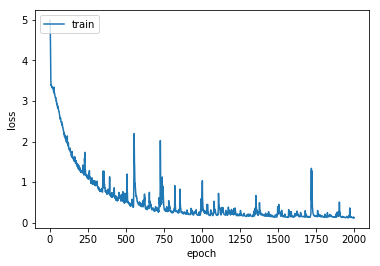

57/57 [==============================] - 0s 2ms/step
acc: 96.49%
one step prediction :  ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'd_oct2_1', 'e_oct1_1_legSt', 'd_oct1_1_legEnd', 'c_oct1_1', 'b_oct0_3', 'd_oct1_2', 'e_oct1_1', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'c_oct2_1_legEnd', 'e_oct2_2', 'd_oct2_1', 'c_oct2_1', 'b_oct1_1', 'a_oct1_1', 'f_oct1_3', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'e_oct1_1', 'g_oct1_1', 'f_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1']
full song prediction :  ['a_oct1_3', 'd_oct2_2', 'c_o

In [4]:
# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(350, input_shape = (4, 1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=14, verbose=2, callbacks=[history])

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 57 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

Result(LSTM)

acc: 96.49%
one step prediction :  \['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'd_oct2_1', 'e_oct1_1_legSt', 'd_oct1_1_legEnd', 'c_oct1_1', 'b_oct0_3', 'd_oct1_2', 'e_oct1_1', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'c_oct2_1_legEnd', 'e_oct2_2', 'd_oct2_1', 'c_oct2_1', 'b_oct1_1', 'a_oct1_1', 'f_oct1_3', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'e_oct1_1', 'g_oct1_1', 'f_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1'\]

full song prediction :  \['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd'\]
